In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
data = pd.read_csv("car_fuel_efficiency.csv")
data.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [6]:
selected_columns = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
new_data = data[selected_columns]
new_data.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


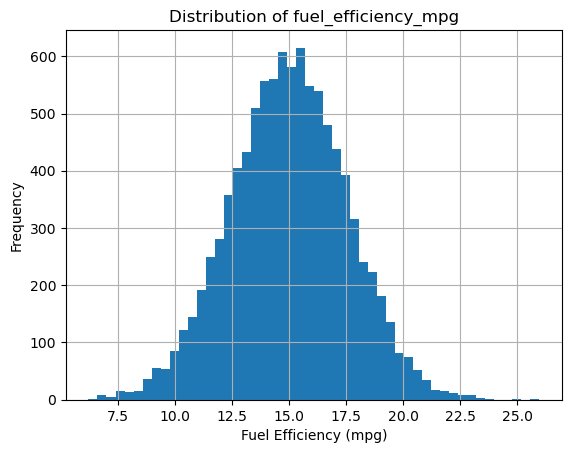

Skewness of fuel_efficiency_mpg: -0.012062219273507929


In [7]:
new_data['fuel_efficiency_mpg'].hist(bins=50)
plt.xlabel('Fuel Efficiency (mpg)')
plt.ylabel('Frequency')
plt.title('Distribution of fuel_efficiency_mpg')
plt.show() # the distribution appears fairly symmetrical

# Calculate skewness to quantify tail behavior
skewness = new_data['fuel_efficiency_mpg'].skew()
print('Skewness of fuel_efficiency_mpg:', skewness) # -0.01206 means it doesn't show a pronounced long tail

In [8]:
missing_counts = new_data.isnull().sum()
missing_counts

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [9]:
median_horsepower = new_data['horsepower'].median()
median_horsepower

149.0

In [17]:
n_samples = len(new_data)
n_val = int(n_samples * 0.2)
n_test = int(n_samples * 0.2)
n_train = n_samples - n_val - n_test

idx = np.arange(n_samples)
np.random.seed(42)
np.random.shuffle(idx)

train_data = new_data.iloc[idx[:n_train]]
val_data = new_data.iloc[idx[n_train: n_train + n_val]]
test_data = new_data.iloc[idx[n_train + n_val: ]]

In [18]:
train_data.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822
1688,150,206.0,3748.164469,2015,11.818843
6217,300,111.0,2135.716359,2006,19.402209


In [16]:
len(train_data), len(val_data), len(test_data)

(5824, 1940, 1940)

In [19]:
train_data = train_data.reset_index(drop = True)
val_data = val_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

train_data.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,220,144.0,2535.887591,2009,16.642943
1,160,141.0,2741.170484,2019,16.298377
2,230,155.0,2471.880237,2017,18.591822
3,150,206.0,3748.164469,2015,11.818843
4,300,111.0,2135.716359,2006,19.402209


In [21]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Define features and target
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

# 1. Compute mean horsepower on train only
mean_hp = train_data['horsepower'].mean()

# Create two copies of train, val to test imputation methods
train_0 = train_data.copy()
val_0 = val_data.copy()
train_mean = train_data.copy()
val_mean = val_data.copy()

# Impute missing 'horsepower' with 0
train_0['horsepower'] = train_0['horsepower'].fillna(0)
val_0['horsepower'] = val_0['horsepower'].fillna(0)

# Impute missing 'horsepower' with mean (computed on train)
train_mean['horsepower'] = train_mean['horsepower'].fillna(mean_hp)
val_mean['horsepower'] = val_mean['horsepower'].fillna(mean_hp)

# Prepare function to train linear regression (closed form)
def train_linear_regression(df_train, df_val):
    X_train = df_train[features].values
    y_train = df_train[target].values
    X_val = df_val[features].values
    y_val = df_val[target].values

    # Add bias term
    X_train_b = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_val_b = np.hstack([np.ones((X_val.shape[0], 1)), X_val])

    # Closed-form solution
    w = inv(X_train_b.T.dot(X_train_b)).dot(X_train_b.T).dot(y_train)

    # Predict on validation
    y_val_pred = X_val_b.dot(w)

    return round(rmse(y_val, y_val_pred), 2)

# Calculate RMSE for both imputation options
rmse_0 = train_linear_regression(train_0, val_0)
rmse_mean = train_linear_regression(train_mean, val_mean)

print('RMSE with 0 imputation:', rmse_0)
print('RMSE with mean imputation:', rmse_mean)

RMSE with 0 imputation: 0.52
RMSE with mean imputation: 0.46


In [22]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Fill missing values in train and val with 0
train_filled = train_data.copy()
val_filled = val_data.copy()
train_filled['horsepower'] = train_filled['horsepower'].fillna(0)
val_filled['horsepower'] = val_filled['horsepower'].fillna(0)

features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

X_train = train_filled[features].values
y_train = train_filled[target].values
X_val = val_filled[features].values
y_val = val_filled[target].values

# Add bias term
X_train_b = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val_b = np.hstack([np.ones((X_val.shape[0], 1)), X_val])

# Try different values of r (alpha)
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = []

for r in r_values:
    # Ridge regression closed-form solution
    I = np.eye(X_train_b.shape[1])
    I[0, 0] = 0  # Don't regularize the bias term
    w = np.linalg.inv(X_train_b.T.dot(X_train_b) + r * I).dot(X_train_b.T).dot(y_train)
    y_pred = X_val_b.dot(w)
    score = rmse(y_val, y_pred)
    rmse_scores.append(round(score, 2))

for r, score in zip(r_values, rmse_scores):
    print(f"r={r}: RMSE={score}")

# Find the smallest r with the best (lowest) RMSE
best_rmse = min(rmse_scores)
best_r = r_values[rmse_scores.index(best_rmse)]
print(f"Best r: {best_r}, Best RMSE: {best_rmse}")

r=0: RMSE=0.52
r=0.01: RMSE=0.52
r=0.1: RMSE=0.52
r=1: RMSE=0.52
r=5: RMSE=0.52
r=10: RMSE=0.52
r=100: RMSE=0.52
Best r: 0, Best RMSE: 0.52


In [23]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

rmse_scores = []

for seed in range(10):
    n_samples = len(new_data)
    n_val = int(n_samples * 0.2)
    n_test = int(n_samples * 0.2)
    n_train = n_samples - n_val - n_test

    idx = np.arange(n_samples)
    np.random.seed(seed)
    np.random.shuffle(idx)

    train_data = new_data.iloc[idx[:n_train]].copy()
    val_data = new_data.iloc[idx[n_train:n_train + n_val]].copy()
    test_data = new_data.iloc[idx[n_train + n_val:]].copy()

    # Fill missing values with 0
    train_data['horsepower'] = train_data['horsepower'].fillna(0)
    val_data['horsepower'] = val_data['horsepower'].fillna(0)

    X_train = train_data[features].values
    y_train = train_data[target].values
    X_val = val_data[features].values
    y_val = val_data[target].values

    # Add bias term
    X_train_b = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_val_b = np.hstack([np.ones((X_val.shape[0], 1)), X_val])

    # Closed-form solution for linear regression
    w = np.linalg.inv(X_train_b.T.dot(X_train_b)).dot(X_train_b.T).dot(y_train)

    y_val_pred = X_val_b.dot(w)
    score = rmse(y_val, y_val_pred)
    rmse_scores.append(score)

std_rmse = round(np.std(rmse_scores), 3)
print('Standard deviation of RMSE scores:', std_rmse)

Standard deviation of RMSE scores: 0.007


In [24]:
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

# Split with seed 9
n_samples = len(new_data)
n_val = int(n_samples * 0.2)
n_test = int(n_samples * 0.2)
n_train = n_samples - n_val - n_test

idx = np.arange(n_samples)
np.random.seed(9)
np.random.shuffle(idx)

train_data = new_data.iloc[idx[:n_train]].copy()
val_data = new_data.iloc[idx[n_train:n_train + n_val]].copy()
test_data = new_data.iloc[idx[n_train + n_val:]].copy()

# Combine train and val
full_train = pd.concat([train_data, val_data]).reset_index(drop=True)

# Fill missing values with 0
full_train['horsepower'] = full_train['horsepower'].fillna(0)
test_data['horsepower'] = test_data['horsepower'].fillna(0)

X_train = full_train[features].values
y_train = full_train[target].values
X_test = test_data[features].values
y_test = test_data[target].values

# Add bias term
X_train_b = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_b = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Ridge regression with r=0.001
r = 0.001
I = np.eye(X_train_b.shape[1])
I[0, 0] = 0  # Don't regularize the bias
w = np.linalg.inv(X_train_b.T.dot(X_train_b) + r * I).dot(X_train_b.T).dot(y_train)

y_pred_test = X_test_b.dot(w)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

test_rmse = round(rmse(y_test, y_pred_test), 2)
print('Test RMSE:', test_rmse)

Test RMSE: 0.52
